In [1]:
import uproot

In [2]:
def natural_sort(list, key=lambda s:s):
    """
    Sort the list into natural alphanumeric order.
    http://stackoverflow.com/questions/4836710/does-python-have-a-built-in-function-for-string-natural-sort
    """

    import re

    def get_alphanum_key_func(key):
        convert = lambda text: int(text) if text.isdigit() else text
        return lambda s: [convert(c) for c in re.split('([0-9]+)', key(s))]

    sort_key = get_alphanum_key_func(key)

    lc = sorted(list, key=sort_key)

    return lc

combineCards.py naive_stat_unc_2HDMa_sinp_0.35_tanb_1.0_mXd_10_MH3_1900_MH4_250_MH2_1900_MHC_1900_8.txt -S > naive_shapes.txt

combine -M FitDiagnostics naive_shapes.txt --robustHesse 1 --forceRecreateNLL --saveShapes --saveNormalizations --saveOverall --saveWithUncertainties

In [3]:
f_in = "/home/users/dspitzba/stop/combination/CMSSW_10_2_9/src/Stop_Run2/cards/2l/fitDiagnostics.root"

In [4]:
f = uproot.open(f_in)

In [5]:
test = f['shapes_fit_b']

In [6]:
test.keys()

['Bin0;1',
 'Bin0/data;1',
 'Bin0/DY;1',
 'Bin0/TTJets;1',
 'Bin0/TTXNoZ;1',
 'Bin0/TTZ;1',
 'Bin0/multiBoson;1',
 'Bin0/signal;1',
 'Bin0/total;1',
 'Bin0/total_signal;1',
 'Bin0/total_background;1',
 'Bin0/total_covar;1',
 'total_overall;1',
 'total_signal;1',
 'total_data;1',
 'total_background;1',
 'overall_total_covar;1']

In [7]:
in_file = uproot.open(f_in)
shapes = ['shapes_fit_b', 'shapes_fit_s', 'shapes_prefit']
bins = [ x.split('/')[0].replace(';1','') for x in in_file[shapes[0]] ]

In [8]:
list(set(bins))

['total_overall',
 'overall_total_covar',
 'total_signal',
 'total_background',
 'Bin0',
 'total_data']

In [9]:
import numpy as np
def read_fitdiagnostics(in_file):
    shapes = ['shapes_fit_b', 'shapes_fit_s', 'shapes_prefit']
    bins = list(set([ x.split('/')[0].replace(';1','') for x in in_file[shapes[0]] ]))
    #print (bins)
    bins.remove('total_overall')
    bins.remove('overall_total_covar')
    bins.remove('total_data')
    bins.remove('total_background')
    bins.remove('total_signal')
    res = {}
    for shape in shapes:
        res[shape] = {}
        for bin in bins:
            #print (bin)
            res[shape][bin] = {}
            processes = [ x.replace(';1','') for x in in_file[shape][bin].keys() ]
            for process in processes:
                res[shape][bin][process] = {}
                if process == 'data':
                    res[shape][bin][process]['counts'] = in_file[shape][bin][process].values()[1]
                    res[shape][bin][process]['errors'] = np.sqrt(in_file[shape][bin][process].values()[1])
                else:
                    res[shape][bin][process]['counts'] = in_file[shape][bin][process].counts()
                    res[shape][bin][process]['errors'] = in_file[shape][bin][process].errors()

    return res

In [10]:
res = read_fitdiagnostics(in_file)

In [11]:
bins = natural_sort(list(res['shapes_prefit'].keys()))

In [12]:
import pandas as pd

In [13]:
pd.DataFrame(res['shapes_fit_b'])

,Bin0
DY,"{'counts': [444.45956, 205.07611, 3.5633779, 2..."
TTJets,"{'counts': [134166.84, 163008.56, 4.582045, 27..."
TTXNoZ,"{'counts': [479.1908, 558.386, 4.98427, 7.2016..."
TTZ,"{'counts': [226.6175, 248.84636, 46.71523, 182..."
data,"{'counts': [135554.0, 164350.0, 71.0, 317.0, 9..."
multiBoson,"{'counts': [247.45872, 317.58707, 5.161062, 52..."
signal,"{'counts': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
total,"{'counts': [135564.56, 164338.47, 65.00598, 29..."
total_background,"{'counts': [135564.56, 164338.47, 65.00598, 29..."
total_covar,"{'counts': [[748126.9, 801980.9, -54.93304, -4..."


In [14]:
def get_hist(
    res,
    bin_order,
    processes,
):
    values = {proc:np.array([]) for proc in processes}
    errors = {proc:np.array([]) for proc in processes}
    
    for bin in bin_order:
        for proc in processes:
            values[proc] = np.concatenate((
                values[proc],
                res[bin][proc]['counts'],
            ),
            axis=0,
            )
            errors[proc] = np.concatenate((
                errors[proc],
                res[bin][proc]['errors'],
            ),
            axis=0,
            )
    return values, errors
    
    

In [15]:
h = get_hist(res["shapes_prefit"], bins, ['DY', 'TTJets', 'TTXNoZ', 'TTZ', 'multiBoson'])

In [16]:
len(h[0]['DY'])

46

In [17]:
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

In [18]:
def add_uncertainty(values, errors, edges, ax, ratio=False):
    opts = {'step': 'post', 'label': 'Uncertainty', 'hatch': '///',
                    'facecolor': 'none', 'edgecolor': (0, 0, 0, .5), 'linewidth': 0, 'zorder':10.}
    
    if ratio:
        down = np.ones(len(values)) - errors/values
        up = np.ones(len(values)) + errors/values
    else:
        down = values - errors
        up = values + errors
    ax.fill_between(x=edges, y1=np.r_[down, down[-1]], y2=np.r_[up, up[-1]], **opts)

In [19]:
edges = np.linspace(0.5,46.5,47)

#signal_1 = util.load('../1750_250.coffea')
#signal_2 = util.load('../1900_250.coffea')

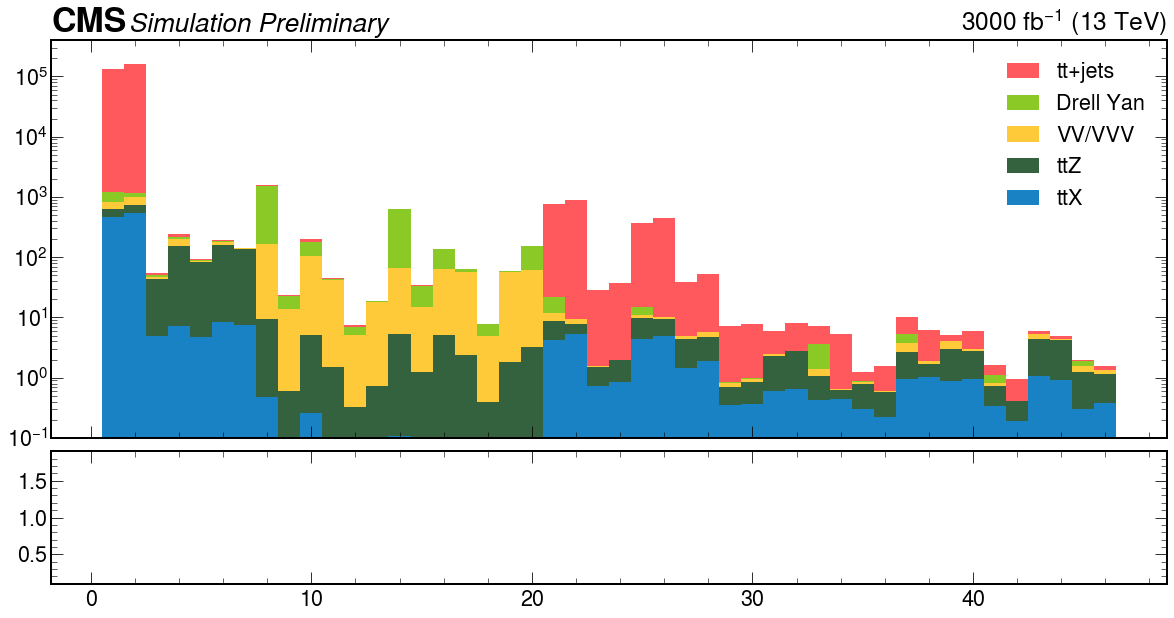

In [20]:

hists = get_hist(
    res["shapes_prefit"],
    bins,
    ['TTXNoZ', 'TTZ', 'multiBoson', 'DY', 'TTJets', 'total'],
)

hist_list = [
    hists[0]['TTXNoZ'],
    hists[0]['TTZ'],
    hists[0]['multiBoson'],
    hists[0]['DY'],
    hists[0]['TTJets'],
]

labels = [
    'ttX',
    'ttZ',
    'VV/VVV',
    'Drell Yan',
    'tt+jets',
]

fig, (ax, rax) = plt.subplots(2,1,figsize=(20,10), gridspec_kw={"height_ratios": (3, 1), "hspace": 0.05}, sharex=True)


hep.cms.label(
    "Preliminary",
    data=False,
    lumi=3000,
    #com=14,
    loc=0,
    ax=ax,
)

hep.histplot(
    hist_list,
    edges,
    histtype="fill",
    stack=True,
    label=labels,
    color=['#1982c4', '#34623f',  '#ffca3a', '#8ac926', '#ff595e' ],
    ax=ax)

#add_uncertainty(hists[0]['total'], hists[1]['total'], edges, ax)
#add_uncertainty(hists[0]['total'], hists[1]['total'], edges, rax, ratio=True)


ax.legend()
ax.set_ylim(0.1,4e5)
rax.set_ylim(0.1,1.9)
ax.set_yscale('log')

plt.show()

## Get original shapes

In [21]:
import uproot

f_in = "/home/users/dspitzba/stop/combination/CMSSW_10_2_9/src/Stop_Run2/cards/2l/T2tt_1052_100_combination_shape.root"
f = uproot.open(f_in)

In [22]:
f.keys()

['data_obs;1',
 'DY;1',
 'DY_DY_SRDown;1',
 'DY_DY_SRUp;1',
 'DY_DY_hMT2llDown;1',
 'DY_DY_hMT2llUp;1',
 'DY_JECDown;1',
 'DY_JECUp;1',
 'DY_JERDown;1',
 'DY_JERUp;1',
 'DY_L1prefireDown;1',
 'DY_L1prefireUp;1',
 'DY_PUDown;1',
 'DY_PUUp;1',
 'DY_SFbDown;1',
 'DY_SFbUp;1',
 'DY_SFlDown;1',
 'DY_SFlUp;1',
 'DY_leptonHit0SFDown;1',
 'DY_leptonHit0SFUp;1',
 'DY_leptonSFDown;1',
 'DY_leptonSFUp;1',
 'DY_leptonSIP3DSFDown;1',
 'DY_leptonSIP3DSFUp;1',
 'DY_triggerDown;1',
 'DY_triggerUp;1',
 'DY_unclEnDown;1',
 'DY_unclEnUp;1',
 'TTJets;1',
 'TTJets_JECDown;1',
 'TTJets_JECUp;1',
 'TTJets_JERDown;1',
 'TTJets_JERUp;1',
 'TTJets_L1prefireDown;1',
 'TTJets_L1prefireUp;1',
 'TTJets_PDFDown;1',
 'TTJets_PDFUp;1',
 'TTJets_PUDown;1',
 'TTJets_PUUp;1',
 'TTJets_SFbDown;1',
 'TTJets_SFbUp;1',
 'TTJets_SFlDown;1',
 'TTJets_SFlUp;1',
 'TTJets_leptonHit0SFDown;1',
 'TTJets_leptonHit0SFUp;1',
 'TTJets_leptonSFDown;1',
 'TTJets_leptonSFUp;1',
 'TTJets_leptonSIP3DSFDown;1',
 'TTJets_leptonSIP3DSFUp;1',
 

In [23]:
f['DY'].errors()[0:2]

array([13.544986,  7.047055])

In [24]:
f['DY'].axes[0].edges()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46.])

In [25]:
processes = ['TTXNoZ', 'TTZ', 'multiBoson', 'DY', 'TTJets']
shape_systematics = ["JEC", "PU", "JER", "unclEn", "trigger", "SFl", "SFb", "leptonSF", "L1prefire", "leptonHit0SF", "leptonSIP3DSF", "PDF", "topPt", "topXSec", "ttZ_SR", "topFakes", "DY_SR", "topNonGauss", "MB_SR", "scaleTT", "scaleTTZ", "DY_hMT2ll", "leptonFS", "btagFS", "isr", "FSmet"]

In [26]:
import boost_histogram as bh

def make_bh(sumw, sumw2, edges):
    h = bh.Histogram(bh.axis.Variable(edges),storage=bh.storage.Weight())
    h.view().value = sumw
    h.view().variance = sumw2
    return h


In [27]:
make_bh(f['DY'].values()[0:2], f['DY'].errors()[0:2]**2, f['DY'].axes[0].edges()[0:3])

Histogram(Variable([0, 1, 2]), storage=Weight()) # Sum: WeightedSum(value=520.332, variance=233.128)

In [28]:
regions = {
    'ttCR': (0,2),
    'ttZCR': (2, 7),
    'DYCR': (7, 20),
    'SR': (20, 46),
}

In [31]:
import os
from Tools.dataCard import dataCard

card = dataCard(releaseLocation=os.path.expandvars('/home/users/dspitzba/TOP/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/'))


In [54]:
card_dir = './testCard/'

all_cards = {}
for reg in regions:
    
    i_min, i_max = regions[reg]
    
    data_card = os.path.abspath(card_dir+reg+'_card.txt')
    shape_file = os.path.abspath(card_dir+reg+'_shapes.root')
    
    f_out = uproot.recreate(shape_file)
    for hist_name in f.keys():
        out_name = hist_name.replace(';1', '')
        tmp = make_bh(
            f[hist_name].values()[i_min:i_max],
            f[hist_name].errors()[i_min:i_max]**2,
            f[hist_name].axes[0].edges()[i_min:i_max+1],
        )
        f_out[out_name] = tmp
    f_out.close()
    
    # set up the card
    #card = dataCard()
    card.reset()
    card.setPrecision(3)
    
    # add the single bin
    card.addBin('Bin0', processes, 'Bin0')
    
    for syst in shape_systematics:
        card.addUncertainty(syst, 'shape')
    
    card.addUncertainty('rare', 'lnN')
    card.addUncertainty('lumi', 'lnN')
    card.specifyFlatUncertainty('lumi', 1.014)
    card.specifyUncertainty('rare', 'Bin0', 'TTXNoZ', 1.25)
    
    for process in processes + ['signal']:
        card.specifyExpectation('Bin0', process, sum(f[process].values()[i_min:i_max]) )
        
        for shape_hist in f.keys():
            if shape_hist.startswith(process):
                process_count = shape_hist.count(process[:8])
                syst_name = shape_hist.replace(f'{process}_','').replace('Down;1','')
                if process_count > 1:
                    syst_name = f"{process}_{syst_name}"
                #print (syst_name)
                if syst_name in shape_systematics:
                    card.specifyUncertainty(syst_name, 'Bin0', process, 1)
                    #card.specifyUncertainty(process, )
                    #print (syst_name)
                    
    card.specifyObservation('Bin0', sum(f['data_obs'].values()[i_min:i_max]))
    
    card.addRateParameter("TTZ", 1, "[0,10]")
    card.addRateParameter("DY", 1, "[0,10]")
    card.addRateParameter("TTJets", 1, "[0,10]")
    card.addRateParameter("multiBoson", 1, "[0.6,1.4]")
    
    c = card.writeToFile(data_card, shapeFile=shape_file)
    all_cards[reg] = c

Adding  lumi = 1.014 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/notebooks/testCard/ttCR_card.txt
Adding  lumi = 1.014 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/notebooks/testCard/ttZCR_card.txt
Adding  lumi = 1.014 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/notebooks/testCard/DYCR_card.txt
Adding  lumi = 1.014 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/notebooks/testCard/SR_card.txt


In [55]:
card.combineCards(all_cards)

Creating /home/users/dspitzba/TOP/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/93109712-00ca-42fd-8457-ae0f5e5335d0
Copying card file to temp: ttCR_card.txt
Copying card file to temp: ttZCR_card.txt
Copying card file to temp: DYCR_card.txt
Copying card file to temp: SR_card.txt
 dc_ttCR=ttCR_card.txt dc_ttZCR=ttZCR_card.txt dc_DYCR=DYCR_card.txt dc_SR=SR_card.txt
Executing cd /home/users/dspitzba/TOP/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/93109712-00ca-42fd-8457-ae0f5e5335d0; eval `scramv1 runtime -sh`; combineCards.py  dc_ttCR=ttCR_card.txt dc_ttZCR=ttZCR_card.txt dc_DYCR=DYCR_card.txt dc_SR=SR_card.txt > combinedCard.txt; text2workspace.py combinedCard.txt --X-allow-no-signal -m 125
Channel dc_ttCR will use autoMCStats with settings: event-threshold=0, include-signal=0, hist-mode=1
Analysing bin errors for: prop_bindc_ttCR
Poisson cut-off: 0
Processes excluded for sums: signal
Bin        Contents        Error           Notes                         
0          132495.590879  

------------------------------------------------------------
21         1.007000        0.179013        total sum                     
21         0.957000        0.178499        excluding marked processes    
21         29.000000       5.385165        Unweighted events, alpha=0.034724
  => Total parameter prop_bindc_SR_bin21[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
22         6.675000        0.586439        total sum                     
22         5.872000        0.581351        excluding marked processes    
22         102.000000      10.099505       Unweighted events, alpha=0.065441
  => Total parameter prop_bindc_SR_bin22[0.00,-7.00,7.00] to be gaussian constrained
------------------------------------------------------------
23         5.851000        0.356048        total sum                     
23         4.897000        0.346691        excluding marked processes    
23         200.000000      14.142136       Unweig

'/home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/notebooks/testCard/combined_card.txt'

# Get the actual covariance matrix

In [64]:
fd = uproot.open("testCard/fitDiagnostics.root")

In [65]:
fd.keys()

['shapes_prefit;1',
 'shapes_prefit/dc_DYCR;1',
 'shapes_prefit/dc_DYCR/data;1',
 'shapes_prefit/dc_DYCR/DY;1',
 'shapes_prefit/dc_DYCR/TTJets;1',
 'shapes_prefit/dc_DYCR/TTXNoZ;1',
 'shapes_prefit/dc_DYCR/TTZ;1',
 'shapes_prefit/dc_DYCR/multiBoson;1',
 'shapes_prefit/dc_DYCR/signal;1',
 'shapes_prefit/dc_DYCR/total;1',
 'shapes_prefit/dc_DYCR/total_signal;1',
 'shapes_prefit/dc_DYCR/total_background;1',
 'shapes_prefit/dc_DYCR/total_covar;1',
 'shapes_prefit/dc_SR;1',
 'shapes_prefit/dc_SR/data;1',
 'shapes_prefit/dc_SR/DY;1',
 'shapes_prefit/dc_SR/TTJets;1',
 'shapes_prefit/dc_SR/TTXNoZ;1',
 'shapes_prefit/dc_SR/TTZ;1',
 'shapes_prefit/dc_SR/multiBoson;1',
 'shapes_prefit/dc_SR/signal;1',
 'shapes_prefit/dc_SR/total;1',
 'shapes_prefit/dc_SR/total_signal;1',
 'shapes_prefit/dc_SR/total_background;1',
 'shapes_prefit/dc_SR/total_covar;1',
 'shapes_prefit/dc_ttCR;1',
 'shapes_prefit/dc_ttCR/data;1',
 'shapes_prefit/dc_ttCR/DY;1',
 'shapes_prefit/dc_ttCR/TTJets;1',
 'shapes_prefit/dc_tt

In [66]:
fd['shapes_fit_b'].keys()

['dc_DYCR;1',
 'dc_DYCR/data;1',
 'dc_DYCR/DY;1',
 'dc_DYCR/TTJets;1',
 'dc_DYCR/TTXNoZ;1',
 'dc_DYCR/TTZ;1',
 'dc_DYCR/multiBoson;1',
 'dc_DYCR/signal;1',
 'dc_DYCR/total;1',
 'dc_DYCR/total_signal;1',
 'dc_DYCR/total_background;1',
 'dc_DYCR/total_covar;1',
 'dc_SR;1',
 'dc_SR/data;1',
 'dc_SR/DY;1',
 'dc_SR/TTJets;1',
 'dc_SR/TTXNoZ;1',
 'dc_SR/TTZ;1',
 'dc_SR/multiBoson;1',
 'dc_SR/signal;1',
 'dc_SR/total;1',
 'dc_SR/total_signal;1',
 'dc_SR/total_background;1',
 'dc_SR/total_covar;1',
 'dc_ttCR;1',
 'dc_ttCR/data;1',
 'dc_ttCR/DY;1',
 'dc_ttCR/TTJets;1',
 'dc_ttCR/TTXNoZ;1',
 'dc_ttCR/TTZ;1',
 'dc_ttCR/multiBoson;1',
 'dc_ttCR/signal;1',
 'dc_ttCR/total;1',
 'dc_ttCR/total_signal;1',
 'dc_ttCR/total_background;1',
 'dc_ttCR/total_covar;1',
 'dc_ttZCR;1',
 'dc_ttZCR/data;1',
 'dc_ttZCR/DY;1',
 'dc_ttZCR/TTJets;1',
 'dc_ttZCR/TTXNoZ;1',
 'dc_ttZCR/TTZ;1',
 'dc_ttZCR/multiBoson;1',
 'dc_ttZCR/total;1',
 'dc_ttZCR/total_background;1',
 'dc_ttZCR/total_covar;1',
 'total_overall;1',
 '

In [81]:
covar = fd['shapes_fit_b']['overall_total_covar']
covar.values()

array([[3911.0170671 ,   51.58818935,  348.55889643, ...,    0.        ,
           0.        ,    0.        ],
       [  51.58818935,    6.62431382,    8.21204646, ...,    0.        ,
           0.        ,    0.        ],
       [ 348.55889643,    8.21204646,  140.11728585, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ]])

In [96]:
covar.axes[0].labels().index('dc_ttCR_2')

54

In [90]:
np.shape(covar.values())

(104, 104)

In [94]:
# need to get the relevant bins

In [95]:
covar.axes[0].labels() == covar.axes[1].labels()

True

In [116]:
covar.axes[0].labels().index('dc_ttCR_3')  ## this should not exist

55

In [117]:
## therefore all these entries should be 0!

covar.values()[55]  

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [212]:
region_names = []
for reg in regions:
    for i in range(regions[reg][1]-regions[reg][0]):
        region_names.append(f'dc_{reg}_{i}')
region_names

['dc_ttCR_0',
 'dc_ttCR_1',
 'dc_ttZCR_0',
 'dc_ttZCR_1',
 'dc_ttZCR_2',
 'dc_ttZCR_3',
 'dc_ttZCR_4',
 'dc_DYCR_0',
 'dc_DYCR_1',
 'dc_DYCR_2',
 'dc_DYCR_3',
 'dc_DYCR_4',
 'dc_DYCR_5',
 'dc_DYCR_6',
 'dc_DYCR_7',
 'dc_DYCR_8',
 'dc_DYCR_9',
 'dc_DYCR_10',
 'dc_DYCR_11',
 'dc_DYCR_12',
 'dc_SR_0',
 'dc_SR_1',
 'dc_SR_2',
 'dc_SR_3',
 'dc_SR_4',
 'dc_SR_5',
 'dc_SR_6',
 'dc_SR_7',
 'dc_SR_8',
 'dc_SR_9',
 'dc_SR_10',
 'dc_SR_11',
 'dc_SR_12',
 'dc_SR_13',
 'dc_SR_14',
 'dc_SR_15',
 'dc_SR_16',
 'dc_SR_17',
 'dc_SR_18',
 'dc_SR_19',
 'dc_SR_20',
 'dc_SR_21',
 'dc_SR_22',
 'dc_SR_23',
 'dc_SR_24',
 'dc_SR_25']

In [140]:
indices = [covar.axes[0].labels().index(n) for n in region_names]

In [147]:
# get the full rank covariance matrix
cov_matrix = covar.values()[np.expand_dims(indices, axis=1), indices]

In [152]:
np.sqrt(cov_matrix[45,45])

0.43338187517058174

Text(0.5, 1.0, 'Correlation Matrix')

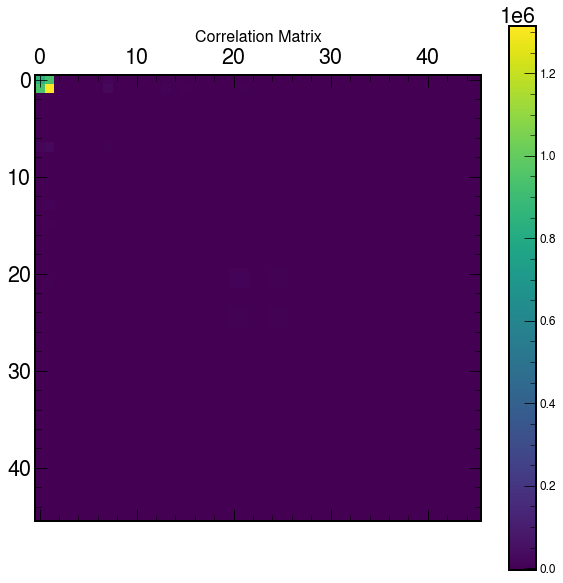

In [148]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
    
im = ax.matshow(cov_matrix)
#ax.set_xticks(range(df.select_dtypes(['number']).shape[1]))
#ax.set_xticklabels(df.select_dtypes(['number']).columns, rotation=90, fontdict={'fontsize':12})
#ax.set_yticks(range(df.select_dtypes(['number']).shape[1]))
#ax.set_yticklabels(df.select_dtypes(['number']).columns, fontdict={'fontsize':12})
cbar = ax.figure.colorbar(im)
cbar.ax.tick_params(labelsize=12)

ax.set_title('Correlation Matrix', fontsize=16)

## Sanity check with the 1D histogram

In [156]:
fd['shapes_fit_b']['total_background'].values()[indices]

array([1.35574797e+05, 1.64326297e+05, 6.50487061e+01, 2.91169312e+02,
       1.10106552e+02, 2.35720413e+02, 1.72757645e+02, 1.99114624e+03,
       3.17832203e+01, 2.49126526e+02, 5.95659485e+01, 1.03005629e+01,
       2.28923912e+01, 6.74447815e+02, 4.13922615e+01, 1.58224518e+02,
       8.48528137e+01, 1.02432842e+01, 7.03227539e+01, 1.47550110e+02,
       8.24923889e+02, 9.46343262e+02, 3.24726791e+01, 4.25383720e+01,
       4.08926544e+02, 4.89057983e+02, 4.48985596e+01, 5.97176933e+01,
       8.24878407e+00, 9.14620018e+00, 6.90550709e+00, 9.35948086e+00,
       8.43102360e+00, 6.11920643e+00, 1.46606910e+00, 1.87860858e+00,
       1.21974077e+01, 7.36159754e+00, 6.38772297e+00, 7.01725340e+00,
       1.88457978e+00, 1.11502588e+00, 7.00537586e+00, 5.88611174e+00,
       2.22859430e+00, 1.78701842e+00])

In [157]:
fd['shapes_fit_b']['total_background'].errors()[indices]

array([9.20017478e+02, 1.14655142e+03, 2.58267957e+00, 9.40482080e+00,
       4.35591050e+00, 8.31881867e+00, 6.59783382e+00, 6.25381284e+01,
       2.57377426e+00, 1.18371147e+01, 4.55274213e+00, 1.20788583e+00,
       2.33145263e+00, 2.52741871e+01, 2.96238277e+00, 6.10900414e+00,
       5.28193159e+00, 1.10924085e+00, 5.00694123e+00, 8.08401351e+00,
       9.39748204e+01, 1.08695653e+02, 5.11936809e+00, 6.36519390e+00,
       5.05920155e+01, 6.04695895e+01, 6.75333360e+00, 8.96759983e+00,
       1.60777786e+00, 1.83689528e+00, 1.09788299e+00, 1.58458137e+00,
       1.71826023e+00, 1.78602772e+00, 2.77349905e-01, 6.60751771e-01,
       2.35728760e+00, 1.61913747e+00, 9.85895481e-01, 1.38789750e+00,
       3.66376161e-01, 2.58173178e-01, 1.16439973e+00, 9.99655702e-01,
       6.09365359e-01, 4.33381912e-01])

In [159]:
np.sqrt(cov_matrix.diagonal())

array([9.20017483e+02, 1.14655146e+03, 2.58267939e+00, 9.40482116e+00,
       4.35591025e+00, 8.31881898e+00, 6.59783388e+00, 6.25381249e+01,
       2.57377424e+00, 1.18371148e+01, 4.55274189e+00, 1.20788571e+00,
       2.33145275e+00, 2.52741897e+01, 2.96238209e+00, 6.10900459e+00,
       5.28193209e+00, 1.10924091e+00, 5.00694101e+00, 8.08401450e+00,
       9.39748254e+01, 1.08695663e+02, 5.11936872e+00, 6.36519400e+00,
       5.05920192e+01, 6.04695920e+01, 6.75333366e+00, 8.96759995e+00,
       1.60777793e+00, 1.83689522e+00, 1.09788311e+00, 1.58458148e+00,
       1.71826025e+00, 1.78602791e+00, 2.77349953e-01, 6.60751657e-01,
       2.35728739e+00, 1.61913763e+00, 9.85895394e-01, 1.38789773e+00,
       3.66376108e-01, 2.58173177e-01, 1.16439981e+00, 9.99655711e-01,
       6.09365373e-01, 4.33381875e-01])

In [162]:
np.sqrt(cov_matrix.diagonal())[44:]/fd['shapes_fit_b']['total_background'].values()[indices][44:]

array([0.27343037, 0.24251674])

In [166]:
fd['shapes_fit_b']['total_background'].values()[indices][20:46]

array([824.92388916, 946.34326172,  32.47267914,  42.53837204,
       408.92654419, 489.0579834 ,  44.89855957,  59.71769333,
         8.24878407,   9.14620018,   6.90550709,   9.35948086,
         8.4310236 ,   6.11920643,   1.4660691 ,   1.87860858,
        12.19740772,   7.36159754,   6.38772297,   7.0172534 ,
         1.88457978,   1.11502588,   7.00537586,   5.88611174,
         2.2285943 ,   1.78701842])

In [167]:
fd['shapes_prefit']['total_background'].values()[indices][20:46]

array([770.25500488, 885.11199951,  28.22800064,  37.04999542,
       373.22399902, 447.1449585 ,  38.9849968 ,  51.96099472,
         7.09900045,   7.81699991,   6.06400013,   8.04400063,
         7.35099983,   5.30300045,   1.24199998,   1.579     ,
        10.17300034,   6.28099966,   5.18900013,   5.96399975,
         1.61800003,   0.95700002,   5.87199974,   4.89700031,
         1.97599995,   1.5480001 ])

# Export

In [175]:
import copy

In [218]:
template_2D = {
    'independent_variables': [
        {
            'header': {"name": "x-axis", "units": "-"},
            'values': [],
        },
        {
            'header': {"name": "y-axis", "units": "-"},
            'values': [],
        },],
    'dependent_variables': [
        {
            'header': {"name": "covariance", "units": "-"},
            'values': [],
        }

    ]
}

template_1D = {
    'independent_variables': [
        {
            'header': {"name": "x-axis", "units": "GeV"},
            'values': [],
        },
        ],
    'dependent_variables': [
        {
            'header': {"name": "actual values", "units": "GeV"},
            'values': [],
        }

    ]
}

In [203]:
X, Y = np.meshgrid(range(46), range(46))

In [204]:
cov_matrix.flatten()

array([8.46432168e+05, 9.33664313e+05, 3.74595078e+01, ...,
       2.26363525e-01, 1.21632857e-01, 1.87819850e-01])

In [205]:
cov_hepdata = copy.deepcopy(template_2D)

In [214]:
nice_names = ['TT_CR_SF',
 'TT_CR_DF',
 'TTZ_2j2b',
 'TTZ_3j1b',
 'TTZ_3j2b',
 'TTZ_4j1b',
 'TTZ_4j2b',
 'CR0',
 'CR1',
 'CR2',
 'CR3',
 'CR4',
 'CR5',
 'CR6',
 'CR7',
 'CR8',
 'CR9',
 'CR10',
 'CR11',
 'CR12',
 'SR0_SF',
 'SR0_DF',
 'SR1_SF',
 'SR1_DF',
 'SR2_SF',
 'SR2_DF',
 'SR3_SF',
 'SR3_DF',
 'SR4_SF',
 'SR4_DF',
 'SR5_SF',
 'SR5_DF',
 'SR6_SF',
 'SR6_DF',
 'SR7_SF',
 'SR7_DF',
 'SR8_SF',
 'SR8_DF',
 'SR9_SF',
 'SR9_DF',
 'SR10_SF',
 'SR10_DF',
 'SR11_SF',
 'SR11_DF',
 'SR12_SF',
 'SR12_DF',
 ]


In [215]:
cov_hepdata['independent_variables'][0]['values'] = [ {'value': nice_names[x]} for x in X.flatten() ]
cov_hepdata['independent_variables'][1]['values'] = [ {'value': nice_names[x]} for x in Y.flatten() ]
cov_hepdata['dependent_variables'][0]['values'] = [ {'value': round(float(x),2)} for x in cov_matrix.flatten() ]

In [221]:
from yaml import load, dump

try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

f_out = 'covariance.yaml'
with open(f_out, 'w') as f:
    dump(cov_hepdata, f, Dumper=Dumper)

In [222]:
type(list(cov_matrix.flatten()))

list

In [227]:
prefit_hepdata = copy.deepcopy(template_1D)

prefit_hepdata['independent_variables'][0]['values'] = [{'value': n} for n in nice_names]

val_tuple = zip(
    fd['shapes_prefit']['total_background'].values()[indices],
    fd['shapes_prefit']['total_background'].errors()[indices],
)

prefit_hepdata['dependent_variables'][0]['values'] = [ {'value': round(float(x),2), 'errors': [{'symerror':round(float(y),2)}]} for x,y in val_tuple]

f_out = 'prefit.yaml'
with open(f_out, 'w') as f:
    dump(prefit_hepdata, f, Dumper=Dumper)

In [228]:
postfit_hepdata = copy.deepcopy(template_1D)

postfit_hepdata['independent_variables'][0]['values'] = [{'value': n} for n in nice_names]

val_tuple = zip(
    fd['shapes_fit_b']['total_background'].values()[indices],
    fd['shapes_fit_b']['total_background'].errors()[indices],
)

postfit_hepdata['dependent_variables'][0]['values'] = [ {'value': round(x,2), 'errors': [{'symerror': round(y,2)}]} for x,y in val_tuple]

f_out = 'postfit.yaml'
with open(f_out, 'w') as f:
    dump(postfit_hepdata, f, Dumper=Dumper)